In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

In [3]:
path = untar_data(URLs.PETS)

In [4]:
(path / 'images').ls()

(#7393) [Path('/home/florian/.fastai/data/oxford-iiit-pet/images/Persian_1.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/Siamese_176.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/basset_hound_96.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/japanese_chin_81.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/chihuahua_148.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_176.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/chihuahua_136.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/american_bulldog_48.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/shiba_inu_126.jpg'),Path('/home/florian/.fastai/data/oxford-iiit-pet/images/havanese_18.jpg')...]

In [5]:
fname = (path / 'images').ls()[0]

In [6]:
fname

Path('/home/florian/.fastai/data/oxford-iiit-pet/images/Persian_1.jpg')

In [7]:
get_image_files

<function fastai.data.transforms.get_image_files(path, recurse=True, folders=None)>

## DataBlock & data loaders

In [8]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=.75)
)


In [9]:
dls = pets.dataloaders(path/'images')

In [10]:
# pets.summary(path/'images')

## Learner (= the model)

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/florian/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.561578,0.342588,0.115020,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.512807,0.270266,0.081867,00:30
1,0.326168,0.211638,0.067659,00:30


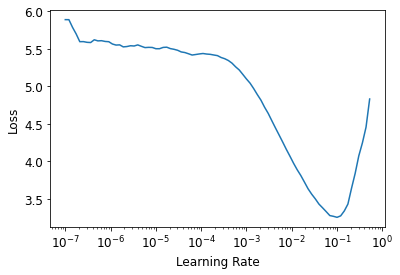

In [18]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [22]:
print(f"Min/10: {lr_min:.4f}/{lr_min:.2e}, steepest at: {lr_steep:4f}/{lr_steep:.2e}")

Min/10: 0.0100/1.00e-02, steepest at: 0.003020/3.02e-03


## Train with bad learning rate

In [20]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.980013,0.516555,0.125846,00:24


epoch,train_loss,valid_loss,error_rate,time
0,1.046275,0.933177,0.228011,00:30
1,0.568675,0.308131,0.096076,00:30


## Train with good learning rate

In [21]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.315702,0.371412,0.119756,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.573829,0.320219,0.099459,00:30
1,0.332614,0.236451,0.075778,00:30


## Transfer learning (step by step)

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

# Start by training one layer only (classification layer)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.169838,0.294825,0.096752,00:25
1,0.527613,0.261868,0.087957,00:25
2,0.339893,0.233072,0.072395,00:25


In [25]:
# Now unfreeze all layers
learn.unfreeze()

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=2.75422871709452e-06)

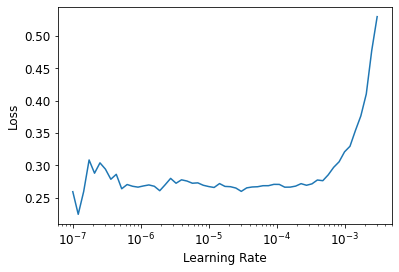

In [26]:
# Find the learning rate again (model behaves differently now!)
learn.lr_find()

In [27]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.272498,0.223318,0.073072,00:30
1,0.255849,0.215808,0.069012,00:31
2,0.230441,0.211564,0.062923,00:31
3,0.208376,0.206094,0.058863,00:31
4,0.200818,0.206155,0.063599,00:31
5,0.180778,0.204719,0.061570,00:31


In [31]:
# LRFinder??
learn.lr_find??

Signature:
learn.lr_find(
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggestions=True,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return SuggestedLRs(lr_min/10.,lr_steep)
File:      ~/